# feature map

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import torch

In [ ]:
# large model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:30<00:00, 39.5MB/s]


In [247]:
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520*2),
                                transforms.CenterCrop(518*2), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])



transform2 = transforms.Compose([
                                transforms.Resize(520*2),
                                transforms.CenterCrop(518*2), #should be multiple of model patch_size
                                ])

In [248]:
patch_size = dinov2_vitl14.patch_size 

patch_h  = 520*2//patch_size
patch_w  = 520*2//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14


total_features  = []
with torch.no_grad():
  for img_path in [
 'clear_90__PICT1829.JPG',
 'clear_91__маралухи_в_снегу.jpg',
 'clear_93__PICT0035.JPG',
 'clear_96__PICT0123.JPG',
 ]:
    img = Image.open('/content/drive/MyDrive/phototrap/photo_traps_dataset/test/animal/base/'+img_path).convert('RGB')
    img_t = transform1(img)

    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 5476, 1024])

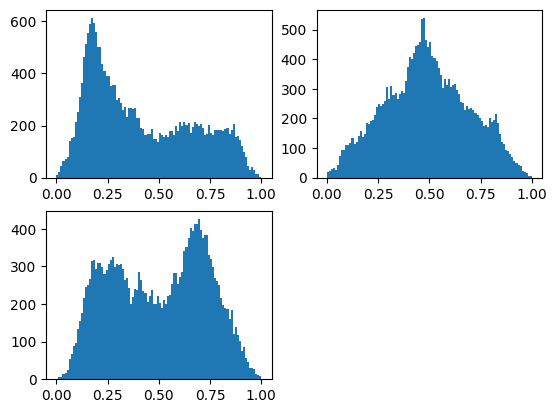

In [249]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
total_features = total_features.reshape(-1, feat_dim) 

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# min_max scale
for i in range(3):
  pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / \
                     (pca_features[:, i].max() - pca_features[:, i].min())

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0], 100)
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1], 100)
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2], 100)
plt.show()
plt.close()

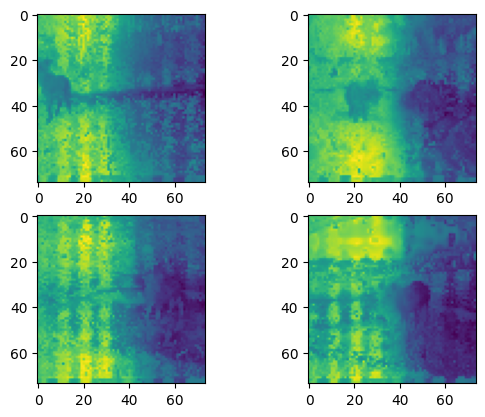

In [259]:
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 2].reshape(patch_h, patch_w))

plt.show()

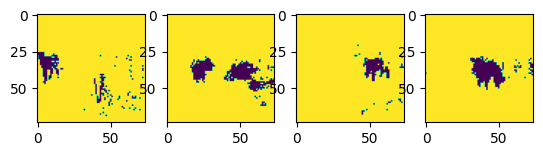

In [577]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = (pca_features[:, 0] < 0.25)|(pca_features[:, 0] > 0.45)
pca_features_bg |= (pca_features[:, 1] < 0.4)|(pca_features[:, 1] > 0.55)
pca_features_bg |= (pca_features[:, 2] < 0.1)|(pca_features[:, 2] > 0.55)

pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


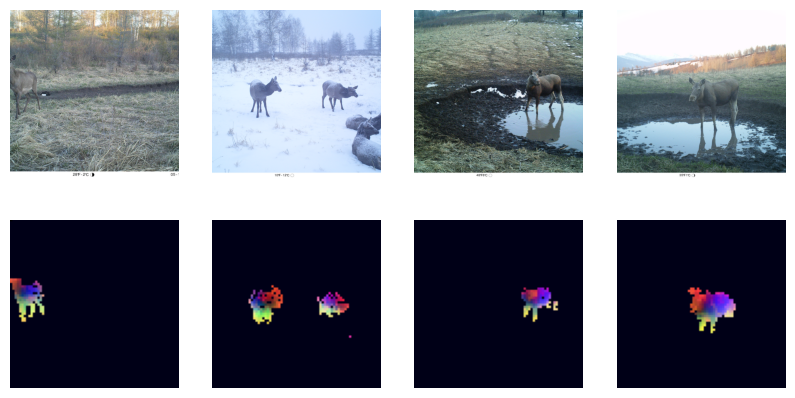

In [597]:
plt.figure(figsize=(10,5))
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)

# final filter
pca_features_rgb[pca_features_rgb[:,:,:,0] > 0.38] = 0
pca_features_rgb[0,0,0,2] = -0.1
for i in range(3):
    # min_max scaling
    pca_features_rgb[:,:,:, i] = (pca_features_rgb[:,:,:, i] - pca_features_rgb[:,:,:, i].min()) / (pca_features_rgb[:,:,:, i].max() - pca_features_rgb[:,:,:, i].min())

for i in range(4):
    plt.subplot(2, 4, 4+i+1)
    plt.imshow(pca_features_rgb[i])
    plt.axis('off')


for i, img_path in enumerate([
 'clear_90__PICT1829.JPG',
 'clear_91__маралухи_в_снегу.jpg',
#  'clear_92__PICT0188.JPG',
 'clear_93__PICT0035.JPG',
#  'clear_94__PICT0495_лось_мол.jpg',
#  'clear_95__PICT0678.JPG',
 'clear_96__PICT0123.JPG',
 ]):
    img = Image.open('/content/drive/MyDrive/phototrap/photo_traps_dataset/test/animal/base/'+img_path).convert('RGB').resize((1000, 700))
    plt.subplot(2, 4, i+1)
    plt.imshow(transform2(img))
    plt.axis('off')
plt.show()


# dataset

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
x = np.array(['bad', 'animal', 'no animal',])
hatka = np.array([316, 92, 1614]) # хатка
diff = np.array([194, 201, 134]) # другие
fdeers = np.array([188, 1346, 37])
fbirds = np.array([211, 600, 27])
fpanthers = np.array([41, 245, 28])
fnegs = np.array([442, 0, 118])
florida = fdeers + fbirds + fpanthers + fnegs # Флорида
swans = np.array([0, 55, 0]) #лебеди
sinth = np.array([144, 0, 0]) #синтетика

In [45]:
df = pd.DataFrame({
    'Хатки, AлтГУ':hatka,
    'Другое, АлтГУ':diff,
    'Флорида':florida,
    'Лебеди Алтая':swans,
    'Синтетика':sinth
}, index=x)

<Axes: >

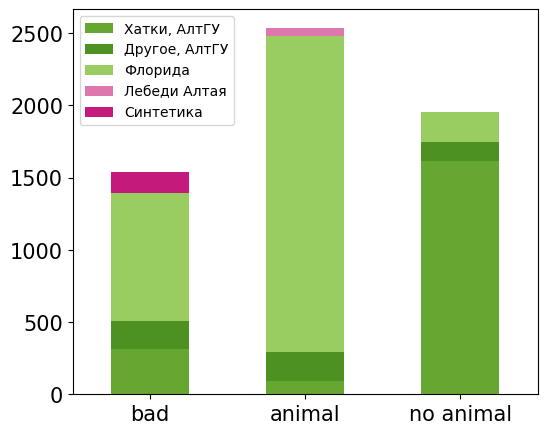

In [54]:
df.plot(kind='bar', stacked=True, fontsize=15, rot=0, figsize=(6,5),
        color=plt.cm.PiYG( [0.85,0.9,0.75,0.2,0.1] ))